In [2]:
! pip install getdist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.6/826.6 kB 8.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.5.4-py3-none-any.whl size=810909 sha256=e87576f0c01db69151aa17362f0a0ca008f6e560481fbce24e5784b9d72f2d4a
  Stored in directory: /root/.cache/pip/wheels/ed/1f/4b/8b586319345aee601e2c6efaf3038891e4e900d68af4eff79f
Successfully built getdist


In [3]:
! pip install emcee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.5 MB/s eta 0:00:00


In [4]:
! git clone https://github.com/fsorrenti/debug.git

Cloning into 'debug'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26 (delta 13), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 10.11 MiB | 11.11 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [5]:
%cd debug

/content/debug


In [1]:
from __future__ import annotations
import sys
import numpy as np
from scipy.stats import multivariate_normal
#import dipole_utilities as ut
import emcee


In [2]:
from astropy.coordinates import SkyCoord, spherical_to_cartesian
from astropy import units as u
import math as m
from scipy import integrate

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
covf = open("Pantheon+SH0ES_STAT+SYS.cov").readlines()
covl = np.array(covf, dtype="float")
shape = covl[0]  # si prende la misura in questo modo, geniale
covmat = covl[1:].reshape((int(shape), int(shape)))

inv=np.linalg.inv(covmat)


filtered_data_file = np.genfromtxt(
    "Pantheon+SH0ES.dat", usecols=(4, 10, 12, 13, 26, 27, 31, 8), skip_header=1
)


z = filtered_data_file[:, 0]
mu = filtered_data_file[:, 1]
ceph_dis = filtered_data_file[:, 2]
is_cal = filtered_data_file[:, 3]
ra = filtered_data_file[:, 4]
dec = filtered_data_file[:, 5]
v_pec = filtered_data_file[:, 6]
m_b = filtered_data_file[:, 7]


In [4]:
def integrand(z, H0, Omat):
    return 1 / (H0 * m.sqrt(Omat * (1 + z) ** 3 + (1 - Omat)))


def dl_monopole(z, H0, Omat):
    c = 299792.458
    return (
        c * (1 + z) * integrate.romberg(integrand, 0, z, args=(H0, Omat))
    )  # return quad(integrand, 0, z, args=(H0, Omat, Olam))[0]

In [5]:
def monopole(z, H0, Omat):
    return 5 * np.log10((dl_monopole(z, H0, Omat))) + 25

In [44]:
def exp_obs_monopole_with_M(
    M, H0, omega_m, mu, z, is_cal, ceph,
):
    number_of_elements = len(mu)
    exp_obs_mon = np.zeros(number_of_elements)
   # c=0
    for i in range(0, number_of_elements):
        if is_cal[i] == 1:
            exp_obs_mon[i] = mu[i] + M - ceph[i]
            # exp_obs_mon[i]=mu[i]-monopole(z6[i],H0,omega_m)
        else:
            exp_obs_mon[i] = mu[i] + M - monopole(z[i], H0, omega_m)
           # c=c+1

    #print(c)

    return exp_obs_mon

In [64]:
def log_likelihood_agnostic(parameters: list[float], inversed_covariance):

    '''the following for the agnostic taylor expansion'''
#    d1, d2, d3, dM  = parameters

#    res=residual_agnostic_taylor_expansion(d1, d2, d3, dM )

  #  z0, d1, d2, d3, dM  = parameters

    Omat,dM  = parameters



    res=exp_obs_monopole_with_M(dM,72.9, Omat, mu, z, is_cal, ceph_dis)


    chi2 = res @ inversed_covariance @ res
    return -0.5 * chi2  # normalization is constant so can be omitted


In [65]:
def log_prior(theta, priors):

    """
    log-prior for the parameters (uniform)
    """
    # theta is the free parameters, priors is a list of two elements
    mu, halfwidth = priors
    for mu_i, theta_i, halfwidth_i in zip(mu, theta, halfwidth):
        if theta_i > mu_i + halfwidth_i or theta_i < mu_i - halfwidth_i:
            return -np.inf
    return 0


In [66]:
def log_probability(parameters: list[float], priors, inversed_covariance):
    """
    log-probability that governs the rate of acceptance for given proposed parameter.
    """
    lp = log_prior(parameters, priors)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood_agnostic(parameters, inversed_covariance)
    if not np.isfinite(ll):
        return -np.inf

    return lp + ll

In [67]:
def run_MCMC(
    nwalkers,
    number_of_steps,
    parameters_values,
    prior_width,
    outpath=None,
    contd=None,
):
    """
    a wrapper file
    """

    inversed_covariance = inv

    # inversed_covariance=inversed_covariance_data



    if outpath is None:
        outpath = "./results.h5"
    # load data

    # priors
    reference_values = np.array(parameters_values, dtype=float)
    widths = np.array(prior_width)
    priors = [reference_values, widths]

    # initial guess array for each walker:
    x0 = np.random.uniform(
        reference_values - widths,
        reference_values + widths,
        size=(nwalkers, len(reference_values)),
    )
    nwalkers, ndim = x0.shape

    # save file
    backend = emcee.backends.HDFBackend(outpath)
    if contd:  # it is true if you want to continue the run
        print(f"initial size: {backend.iteration}", flush=True)
    else:
        backend.reset(nwalkers, ndim)

        # initialize sampler, run MCMC
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        args=[priors, inversed_covariance],
        backend=backend,
    )

    if contd:
        sampler.run_mcmc(
            None, number_of_steps, progress=True, skip_initial_state_check=True
        )
        print(f"final size: {backend.iteration}", flush=True)
    else:
        sampler.run_mcmc(
            x0, number_of_steps, progress=True, skip_initial_state_check=True
        )


In [68]:
# default output file name
OUTPATH = "test_scratch_72_9.h5"

# MCMC sampler settings
N_WALKERS = 32  # number of walkers
N_CHAIN = 1400  # length of chain for each walker
CONTD = False # set CONTD = True to resume sampling (for specific OUTPATH)
# note: keeping CONTD = False may overwrite an existing file.

PARAMETERS_VALUES = [0.5,0]#per la mia scelta di angoli il coseno puo' essere solo fra 0 e 1
PRIOR_WIDTH = [0.5, 0.5]


In [69]:
if __name__ == "__main__":  # it just execute the function
    # load least-square, bets-fit results by default
    #
    # note:
    # Passing manually defined arrays to 'lstsq_results' argument
    # and setting PRIOR_WIDTH_RATIO = 0 will allow users to define
    # the desired central values and width of the prior manually.
    # If you wish to use different (e.g., Gaussian) priors, define
    # the analytic Gaussian function in MCMC_utils.py file accordingly.
    # q_lstsq, sigma_lstsq = np.loadtxt(lstsq_results_path, unpack=True)

    # run MCMC
    run_MCMC(
        nwalkers=N_WALKERS,
        number_of_steps=N_CHAIN,
        parameters_values=PARAMETERS_VALUES,
        prior_width=PRIOR_WIDTH,
        outpath=OUTPATH,
        contd=CONTD,
    )


100%|██████████| 1400/1400 [36:10<00:00,  1.55s/it]


In [25]:
from getdist import plots, MCSamples
import matplotlib.pyplot as plt


def plot_getdist(
    flatchain,
    names_parameter,
    truth_values=None,
    label_legend=None,
    name_for_saving=None,
    params=None,
    fisher=None,
    smoothing_1D=None,
    smoothing_2D=None,
    legend_fontsize=None,
    ranges=None,
):
    """
    Given a MCMC chain and a set of parameter names, plot the posterior distribution of the parameters.
    flatchain: MCMC chain of parameter values
    names_parameter: names of parameters (in the same order as in the flatchain array)
    truth_values: true parameter values (if known)
    label_legend: label to include in the legend
    name_for_saving: if specified, save the plot as a file with this name
    fisher: if True, interpret the chain as a Fisher matrix instead of a Markov Chain
    legend_fontsize: font size for the legend (default is 15)
    ranges: dictionary of parameter ranges (optional)
    """

    # Set default values
    legend_fontsize = legend_fontsize or 15
    smoothing_1D = smoothing_1D or 0.5
    smoothing_2D = smoothing_2D or 2.5

    # Calculate ranges if not provided
    if ranges is None:
        ranges = {
            name: (
                chain[:, i].mean() - 3 * chain[:, i].std(),
                chain[:, i].mean() + 3 * chain[:, i].std()
            )
            for chain in flatchain
            for i, name in enumerate(names_parameter)
        }

    with plt.rc_context({"mathtext.fontset": "cm", "font.family": "serif"}):
        # Create the plot object and set the plot settings
        g = plots.get_subplot_plotter()

        # Set global plotting settings
        g.settings.legend_fontsize = legend_fontsize
        g.settings.axes_fontsize = 18
        g.settings.axes_labelsize = 24
        g.settings.axis_marker_lw = 1.5
        g.settings.axis_marker_color = "black"
        g.settings.alpha_filled_add = 0.7
        g.settings.alpha_factor_contour_lines = 0.7

        # Create list of samples from flatchain
        samples = [
            MCSamples(
                samples=chain,
                names=names_parameter,
                label=label_legend[i] if label_legend else f'Chain {i+1}',
                ranges=ranges,
                settings={
                    "smooth_scale_1D": smoothing_1D,
                    "smooth_scale_2D": smoothing_2D,
                },
            )
            for i, chain in enumerate(flatchain)
        ]

        # Add fisher samples if given
        if fisher is not None:
            samples += fisher

        # Plot triangle plot with or without truth values
        markers = (
            {names_parameter[i]: truth_values[i] for i in range(len(names_parameter))}
            if truth_values is not None
            else None
        )

        g.triangle_plot(
            samples,
            filled=True,
            markers=markers,
            params=params,
            contour_colors=["tab:blue", "tab:orange", "tab:green"],
            contour_ls=["-", "-", "-"],
            contour_lws=[1.5, 1.5, 1.5],
            legend_loc="upper right",
            line_args=[
                {"ls": "-", "lw": "1.5", "color": "tab:blue"},
                {"ls": "-", "lw": "1.5", "color": "tab:orange"},
                {"ls": "-", "lw": "1.5", "color": "tab:green"},
            ],
            bbox_inches='tight'
        )

        # Save plot if name_for_saving is given
        if name_for_saving is not None:
            g.export(name_for_saving)

        plt.show()


%matplotlib inline
plt.close('all')

In [26]:
! ls

Pantheon+SH0ES.dat          test.ipynb
Pantheon+SH0ES_STAT+SYS.cov test_scratch.h5


In [62]:
reader = emcee.backends.HDFBackend("test_scratch_73_4.h5")
tau = reader.get_autocorr_time()
print(tau)
burnin = 60
burnin = int(2 * np.max(tau))
test=reader.get_chain(flat=True, discard=burnin)

c=299792.458
chi=-2 * reader.get_log_prob(flat=True, discard=burnin)


[26.00187544 19.79743517]


Removed no burn in


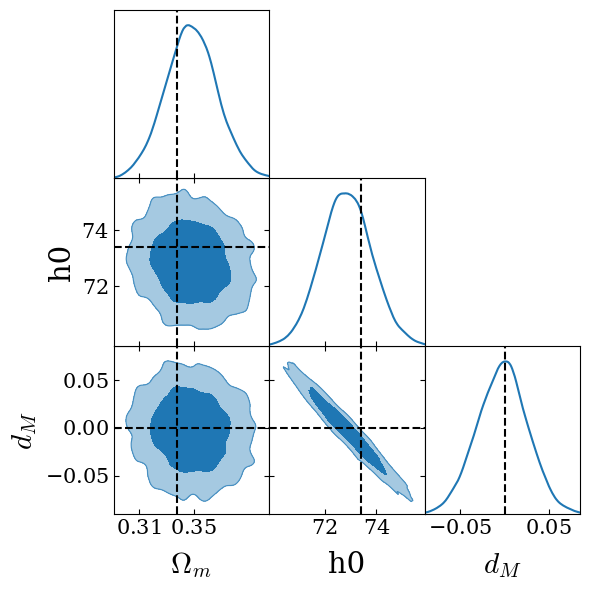

In [42]:
plot_getdist([test], names_parameter=[r'$\Omega_{m}$',r'$H_0$',  r'$dM$'],truth_values=[0.338,73.4,0],smoothing_1D=0.2,smoothing_2D=0.2,)
plt.show()